# Magnetização Induzida e Remanente

Este é o <a href="https://jupyter.org/">Jupyter Notebook</a>, um ambiente interativo de programação e computação. Para este laboratório, você não terá que escrever nenhum código, apenas executá-lo.

Este notebook é uma tradução e adapção do notebook <a href="https://github.com/geoscixyz/geosci-labs/blob/main/notebooks/mag/MagneticPrismApplet.ipynb">MagneticPrismApplet.ipynb</a> disponível no repositório do <a href="https://github.com/geoscixyz/geosci-labs/tree/main">Geosci Labs</a>

Para usar o notebook:
- "Shift + Enter" executa o código dentro da célula (o botão de seta para frente, no topo do documento, também faz isso)
- Você pode alterar variáveis e reexecutar as células
- Se quiser começar do zero, reinicie o Kernel, seja indo até o menu superior e clicando em Kernel: Restart, ou pressionando "esc + 00" (se fizer isso, será necessário reexecutar o bloco de código seguinte antes de rodar qualquer outra célula no notebook)

Este notebook utiliza código adaptado de

SimPEG
- Cockett, R., S. Kang, L.J. Heagy, A. Pidlisecky, D.W. Oldenburg (2015, em revisão), SimPEG: Um framework de código aberto para simulação e estimação de parâmetros baseada em gradiente em aplicações geofísicas. Computers and Geosciences

## Instalações e Importações

In [3]:
## Atualiza o pip
!pip install --upgrade pip

## Instala dependências pelo pip
!pip install simpeg ipywidgets

## Instala o Geosci-Labs pelo GitHub
!pip install git+https://github.com/geoscixyz/geosci-labs.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 4.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.5 MB/s  0:00:00
  Created wheel for simpeg: filename=simpeg-0.24.0-py3-none-any.whl size=585712 sha256=42a128fd9be8f3e5df3e87bb223fd5ec90506181968531c959ba46f3eacbb35d
  Stored in directory: /root/.cache/pip/wheels/9f/ee/b9/5043c4808eb2456a6ee8004e811fa3f9b93b9434f2643b5729
  Created wheel for pymatsolver: filename=pymatsolver-0.3.1-py3-none-any.whl size=16691 sha256=5b0fcf0c3e4cc725ac662510538c15a04340a50996f16d040faae591eeb29b98
  Stored in directory: /root/.cache/pip/wheels/1c/29/30/8c162da2b700a17d43175cc5cc6d36c0460002cf1bfa297f40
Successfully built simpeg pymatsolver
   ━━━━━━━━━━━━━━━━

In [4]:
import numpy as np
from geoscilabs.mag import Mag, Simulator
from SimPEG.potential_fields import magnetics as mag
from SimPEG import utils, data
from discretize import TensorMesh

/tmp/ipython-input-141298955.py:3: FutureWarning: Importing `SimPEG` is deprecated. please import from `simpeg`.
  from SimPEG.potential_fields import magnetics as mag


# Como definimos a direção do campo magnético da Terra?

O campo magnético da Terra é um vetor. Para definir um vetor, precisamos escolher um sistema de coordenadas. Usamos um sistema de mão direita:
- X (Leste),
- Y (Norte), e
- Z (Para cima).

Aqui consideramos um campo magnético da Terra ($\vec{B_0}$) de intensidade unitária. Para definir esse vetor unitário, usamos inclinação e declinação:
- Declinação: Ângulo a partir do Norte geográfico (Ng) (positivo no sentido horário)
- Inclinação: Ângulo vertical a partir do plano N–E (positivo para baixo)

<img src="https://github.com/geoscixyz/geosci-labs/raw/main/images/mag/earthfield.png?raw=true" style="width: 60%; height: 60%"> </img>


# O que são os dados: anomalia do campo total

Consideramos uma forma típica de dados magnéticos. Para ilustrar isso, consideramos um objeto magnetizável em subsuperfície.
Com base no campo magnético da Terra ($\vec{B}_0$), esse objeto gerará um campo magnético anômalo ($\vec{B}_A$). Definimos um vetor unitário $\hat{B}_0$ para o campo da Terra como
$$ \hat{B}_0 = \frac{\vec{B}_0}{|\vec{B}_0|}$$
Medimos tanto o campo terrestre quanto o campo anômalo de modo que

$$ \vec{B} = \vec{B}_0 + \vec{B}_A$$

A anomalia do campo total, $\triangle \vec{B}$, pode ser definida como

$$  |\triangle \vec{B}| = |\vec{B}|-|\vec{B}_E| $$

Se $|\vec{B}|\ll|\vec{B}_E|$, então a anomalia do campo total $\triangle \vec{B}$ é a projeção do campo anômalo na direção do campo terrestre:

$$ |\triangle \vec{B}| \simeq \vec{B}_A \cdot \hat{B}_0=|\vec{B}_A|cos\theta$$

<img src="https://github.com/geoscixyz/geosci-labs/raw/main/images/mag/totalfieldanomaly.png?raw=true" style="width: 50%; height: 50%">


# Visualizando os dados

Os dados magnetométricos que vamos modelar localizam-se sobre o pipe kimberlítico do alvo DO27 (depósito Tli Kwi Cho), Terrtórios do Noroeste, Canadá, e correspondem valores do Campo Magnético Anômalo (CMA). O DO27 caracteriza-se como um corpo kimberlítico com contraste de susceptibilidade magnética relevante, o que o caracteriza como um bom alvo para ser estudado com levantamentos magnetométricos. A amplitude, inclinação e declinação do campo geomagnético na região à época do levantamento são 60,308 nT, 83.8° e 25,4°, respectivamente.

Para saber mais sobre este caso, leia o material disponível no <a href="https://em.geosci.xyz/content/case_histories/do27do18tkc/index.html">EM Geosci</a>.


*Os pontos brancos indicam o plano onde medimos os dados.*


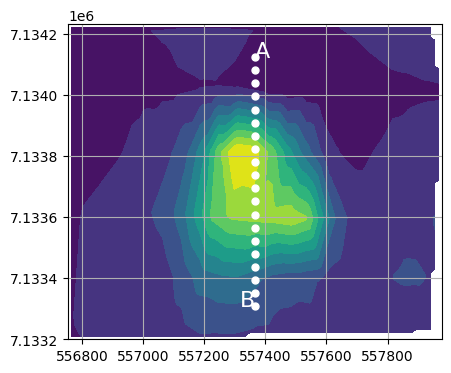

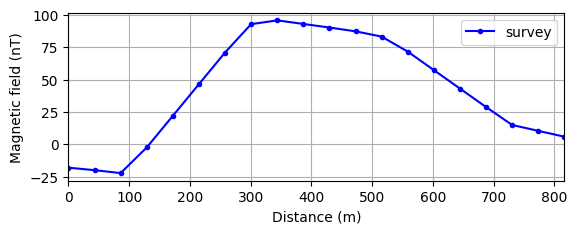

In [36]:
# Parâmetros de entrada
fileName = 'https://github.com/geoscixyz/geosci-labs/raw/main/assets/mag/data/DO27_TMI.dat' ## Arquivo de dados CMA do DO27
xyzd = np.genfromtxt(fileName, skip_header=3)
# B = np.r_[23000, 40, 20] ## Campo geomagnético local
B = np.r_[60308, 83.8, 25.4]
survey, dobj = Mag.createMagSurvey(xyzd, B)

# Visualiza os dados e permite escolher a posição do perfil
param = Simulator.ViewMagSurvey2D(survey, dobj)
param


# Definindo o prisma magnético

Nosso modelo é um prisma retangular, que tentará representar porções magnéticas da estrutura kimberlítica. Os parâmetros para definir esse prisma são:

- dx: comprimento na direção Leste (x) (metro)
- dy: comprimento na direção Norte (y) (metro)
- dz: comprimento na direção Profundidade (z) abaixo do receptor (metro)
- depth: limite superior do prisma (metro)
- pinc: inclinação do prisma (referência: vetor unitário para o Norte; graus)
- pdec: declinação do prisma (referência: vetor unitário para o Norte; graus)

Você também pode alterar a altura da malha de levantamento acima do solo:
- rx_h: altura da malha (metro)

In [37]:
# Define o modelo prismático de modo interativo
model = Simulator.ViewPrism(param.result)
model

interactive(children=(ToggleButton(value=False, description='Refresh'), FloatSlider(value=152.953125, continuo…

# Modelagem do prisma magnético

Com base no prisma que você definiu acima, o applet do prisma magnético abaixo calcula o campo magnético nas posições dos receptores e fornece tanto o mapa 2D (figura superior) quanto a linha de perfil (figura inferior).

Para o prisma, você pode alterar:
- sus: suscetibilidade do prisma

Parâmetros para o campo terrestre:
- Einc: inclinação do campo terrestre (graus)
- Edec: declinação do campo terrestre (graus)
- Bigrf: intensidade do campo terrestre (nT)

Para os dados, você pode visualizar:
- tf: anomalia do campo total,
- bx: componente x,
- by: componente y,
- bz: componente z

Você pode simular e visualizar o efeito da magnetização remanente com os parâmetros:
- irt: "induced", "remanent" ou "total"
- Q: razão de Koenigsberger ($\frac{M_{rem}}{M_{ind}}$)
- rinc: inclinação da magnetização remanente (graus)
- rdec: declinação da magnetização remanente (graus)


In [39]:
## Simula o modelo prismático
Simulator.PFSimulator(model, param)

interactive(children=(ToggleButton(value=False, description='Refresh'), FloatSlider(value=0.1, continuous_upda…